# Great Salt Lake Elevation: Prediction with Neural Networks

Tyler Nelson - A02397541 - CS 5600 Intelligent Systems
- This Jupyter Notebook was heavily inspired by my Machine Learning class that I also took this semester. 
- See my report for analysis

#### Contents
- [1. Imports](#1-imports)
- [2. Combining Datasets](#2-combining-datasets)
- [3. Data Exploration and Gap Interpolation](#3-data-exploration-and-gap-interpolations)
- [4. Feature Engineering](#4-feature-engineering)
- [5. Data Splitting](#5-data-splitting)
- [6. Transformations](#6-transforming)
- [7. Training](#7-training)
- [8. Model Evaluation](#8-model-evaluation)
- [9. Sequence Model](#9-sequence-model)
- [10. Sequence Model Hyperparameter Tuning](#10-sequence-model-hyperparameter-tuning)

### 1. Imports

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Transforming and scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Sequence Model
import tensorflow as tf
from tensorflow.keras import layers, models
from itertools import product


### 2. Combining Datasets

In [890]:
# import all six datasets
DIR = "../data/unprocessed/"
farmington_df = pd.read_csv(
    DIR + "farmington_daily_tab.txt",
    sep="\t",
    comment="#", # ignore commented lines
    parse_dates=["datetime"], # auto-convert to datetime (hopefully)
    dtype=str # prevents Pandas from struggling with mixed types, will convert later
)
corrine_df = pd.read_csv(
    DIR + "corinne_daily_tab.txt",
    sep="\t",
    comment="#",
    parse_dates=["datetime"],
    dtype=str
)
magna_df = pd.read_csv(
    DIR + "magna_daily_tab.txt",
    sep="\t",
    comment="#",
    parse_dates=["datetime"],
    dtype=str
)
weber_df = pd.read_csv(
    DIR + "weber_daily_tab.txt",
    sep="\t",
    comment="#",
    parse_dates=["datetime"],
    dtype=str
)
lake_level_df = pd.read_csv(
    DIR + "lake_level.csv",
    parse_dates=["time"],
)
weather_df = pd.read_csv(
    DIR + "weather.csv",
    skiprows=19,
    parse_dates=["date_time"],
    na_values=["M", "T"]
)
lake_level_df.head()

/var/folders/k_/0zyn6pnd66d9rt5x3h3v_d3m0000gn/T/ipykernel_79186/2549293587.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  farmington_df = pd.read_csv(
/var/folders/k_/0zyn6pnd66d9rt5x3h3v_d3m0000gn/T/ipykernel_79186/2549293587.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  corrine_df = pd.read_csv(
/var/folders/k_/0zyn6pnd66d9rt5x3h3v_d3m0000gn/T/ipykernel_79186/2549293587.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  magna_df = pd.read_csv(
/var/folders/k_/0zyn6pnd66d9rt5x3h3v_d3m0000gn/T/ipykernel_79186/2549293587.py:24: UserWarning: Could not infer for

,x,y,monitoring_location_id,statistic_id,time,unit_of_measure,approval_status,time_series_id,parameter_code,value,qualifier,last_modified
0,-112.496903,41.255211,USGS-10010100,3,2025-12-08,ft,Provisional,2e4657553ff7486d84e1ae1c10a0d34c,62614,4190.8,NaN,2025-12-09 10:55:16.639340+00:00
1,-112.496903,41.255211,USGS-10010100,3,2025-12-07,ft,Provisional,2e4657553ff7486d84e1ae1c10a0d34c,62614,4190.8,NaN,2025-12-08 11:04:28.914723+00:00
2,-112.496903,41.255211,USGS-10010100,3,2025-12-06,ft,Provisional,2e4657553ff7486d84e1ae1c10a0d34c,62614,4190.9,NaN,2025-12-07 11:09:42.982472+00:00
3,-112.496903,41.255211,USGS-10010100,3,2025-12-05,ft,Provisional,2e4657553ff7486d84e1ae1c10a0d34c,62614,4190.7,NaN,2025-12-06 10:58:56.834157+00:00
4,-112.496903,41.255211,USGS-10010100,3,2025-12-04,ft,Provisional,2e4657553ff7486d84e1ae1c10a0d34c,62614,4190.8,NaN,2025-12-05 11:25:48.197980+00:00


In [891]:
# fix lake level data: remove all columns except date and lake level
lake_level_df = lake_level_df[["time", "value"]]
lake_level_df = lake_level_df.rename(columns={"time": "date", "value": "elevation_ft"})

# fix weather data: remove unneeded columns, rename columns
weather_df = weather_df.rename(columns={"date_time": "date"})

# fix farmington data: convert columns to numeric where possible
farmington_df = farmington_df[(farmington_df["agency_cd"] == "USGS") | (farmington_df["agency_cd"] == "agency_cd")]
farmington_df = farmington_df.reset_index(drop=True)
farmington_df = farmington_df[["datetime", "143985_00060_00003"]]
farmington_df = farmington_df.rename(columns={"datetime": "date", "143985_00060_00003": "farmington_inflow"})
farmington_df["farmington_inflow"] = pd.to_numeric(farmington_df["farmington_inflow"], errors="coerce")

# fix weber data
weber_df = weber_df[(weber_df["agency_cd"] == "USGS") | (weber_df["agency_cd"] == "agency_cd")]
weber_df = weber_df.reset_index(drop=True)
weber_df = weber_df[["datetime", "143567_00060_00003"]]
weber_df = weber_df.rename(columns={"datetime": "date", "143567_00060_00003": "weber_inflow"})
weber_df["weber_inflow"] = pd.to_numeric(weber_df["weber_inflow"], errors="coerce")

# fix corinne data
corrine_df = corrine_df[(corrine_df["agency_cd"] == "USGS") | (corrine_df["agency_cd"] == "agency_cd")]
corrine_df = corrine_df.reset_index(drop=True)
corrine_df = corrine_df[["datetime", "143472_00060_00003"]]
corrine_df = corrine_df.rename(columns={"datetime": "date", "143472_00060_00003": "corrine_inflow"})
corrine_df["corrine_inflow"] = pd.to_numeric(corrine_df["corrine_inflow"], errors="coerce")

# fix magna data
magna_df = magna_df[(magna_df["agency_cd"] == "USGS") | (magna_df["agency_cd"] == "agency_cd")]
magna_df = magna_df.reset_index(drop=True)
magna_df = magna_df[["datetime", "143741_00060_00003"]]
magna_df = magna_df.rename(columns={"datetime": "date", "143741_00060_00003": "magna_inflow"})
magna_df["magna_inflow"] = pd.to_numeric(magna_df["magna_inflow"], errors="coerce")

corrine_df.head()

,date,corrine_inflow
0,2015-12-09,650.0
1,2015-12-10,620.0
2,2015-12-11,615.0
3,2015-12-12,650.0
4,2015-12-13,780.0


In [892]:
# combine datasets into one large dataframe using date as index
dfs = [lake_level_df, weather_df, farmington_df, magna_df, weber_df, corrine_df]

for i, df in enumerate(dfs):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    dfs[i] = df.set_index("date").sort_index()

gsl_df = pd.concat(dfs, axis=1, join="outer").sort_index()

# just in case I want a df that goes farther back in time or has less data to process
gsl_inflow_only = gsl_df[["elevation_ft", "farmington_inflow", "magna_inflow", "weber_inflow", "corrine_inflow"]].copy()

gsl_df.head()

,elevation_ft,airt_avg,netrad_avg,precip,pressure,rh_max,rh_min,swup_avg,winds_avg,winds_max,farmington_inflow,magna_inflow,weber_inflow,corrine_inflow
date,,,,,,,,,,,,,,
2015-12-09,4190.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,475.0,12.0,111.0,650.0
2015-12-10,4190.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,547.0,12.4,104.0,620.0
2015-12-11,4190.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,589.0,17.3,96.4,615.0
2015-12-12,4190.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596.0,17.9,90.0,650.0
2015-12-13,4190.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.0,16.0,84.3,780.0


In [893]:
# creates a df including all weather data and inflow data
startDate = "2018-02-07"
gsl_df = gsl_df[gsl_df.index >= startDate]

gsl_df.head()

,elevation_ft,airt_avg,netrad_avg,precip,pressure,rh_max,rh_min,swup_avg,winds_avg,winds_max,farmington_inflow,magna_inflow,weber_inflow,corrine_inflow
date,,,,,,,,,,,,,,
2018-02-07,4193.5,44.2,25.553545,0.0,868.0,52.0,0.0,53.111545,1.566,8.948,499.0,122.0,67.0,2460.0
2018-02-08,4193.5,45.7,21.220500,0.0,864.0,61.0,33.0,83.217792,2.237,17.448,457.0,130.0,60.9,2430.0
2018-02-09,4193.6,48.7,10.910333,0.0,855.0,45.0,24.0,61.159208,3.132,18.119,373.0,139.0,56.7,2410.0
2018-02-10,4193.7,34.7,37.422083,0.0,855.0,70.0,26.0,122.069000,2.684,19.461,-326.0,161.0,45.9,2480.0
2018-02-11,4193.6,31.5,17.210000,0.0,854.0,61.0,32.0,96.737792,2.013,12.527,472.0,161.0,42.5,2490.0


[Back to top](#contents)

### 3. Data Exploration and Gap Interpolations

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2863 entries, 2018-02-07 to 2025-12-09
Freq: D
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   elevation_ft       2862 non-null   float64
 1   airt_avg           2850 non-null   float64
 2   netrad_avg         2856 non-null   float64
 3   precip             2856 non-null   float64
 4   pressure           2856 non-null   float64
 5   rh_max             2856 non-null   float64
 6   rh_min             2855 non-null   float64
 7   swup_avg           2856 non-null   float64
 8   winds_avg          2825 non-null   float64
 9   winds_max          2825 non-null   float64
 10  farmington_inflow  2860 non-null   float64
 11  magna_inflow       2862 non-null   float64
 12  weber_inflow       2862 non-null   float64
 13  corrine_inflow     2863 non-null   float64
dtypes: float64(14)
memory usage: 335.5 KB
None


<Axes: xlabel='date'>

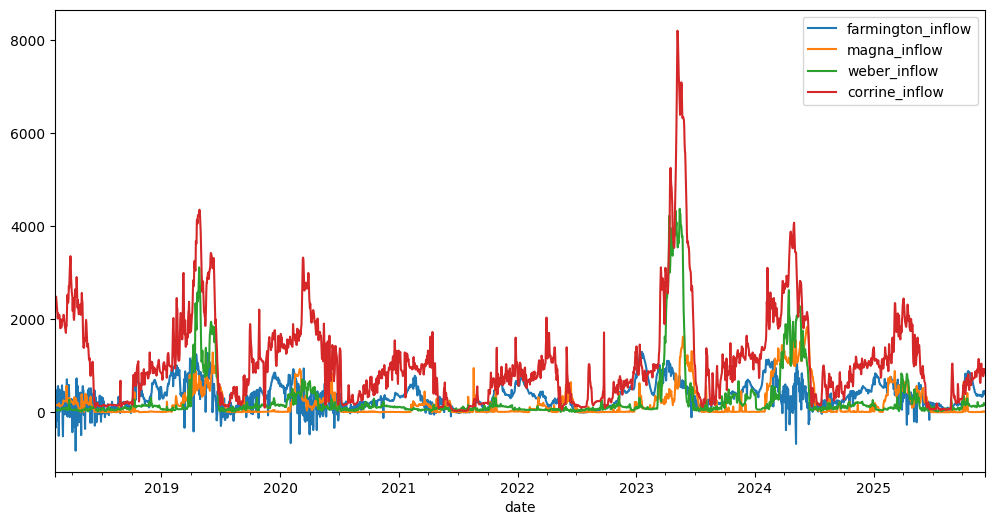

In [894]:
#data validation
print(gsl_df.info())

# negative inflow is fine, as reported by USGS, data flows backwards sometimes into the farmington bay, so no problem there
gsl_df[["farmington_inflow", "magna_inflow",
        "weber_inflow", "corrine_inflow"]].plot(figsize=(12,6))

<Axes: xlabel='date'>

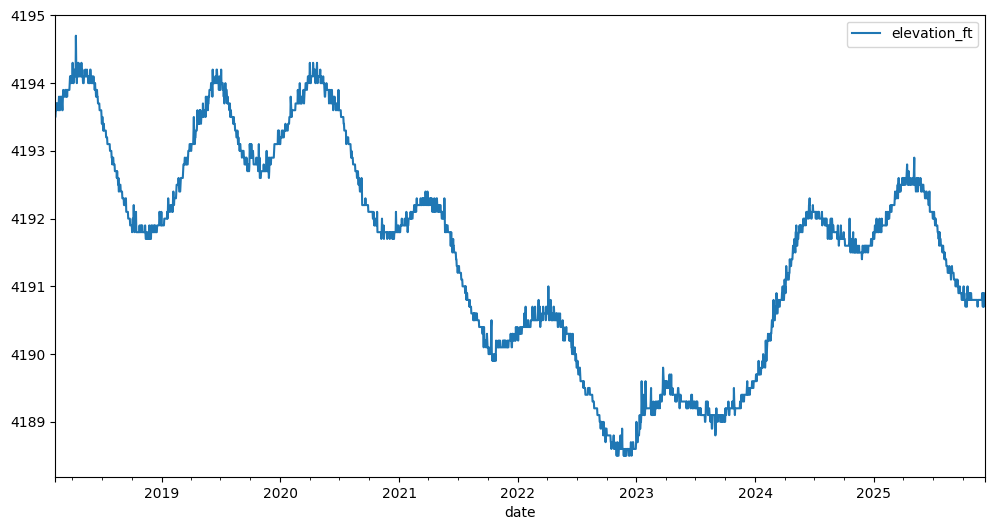

In [895]:
gsl_df[["elevation_ft"]].plot(figsize=(12,6))

In [896]:
gsl_df.describe().T

,count,mean,std,min,25%,50%,75%,max
elevation_ft,2862.0,4191.527952,1.578172,4188.500000,4190.30000,4191.800000,4192.700000,4194.700000
airt_avg,2850.0,49.328912,23.490807,-191.600000,34.50000,49.300000,66.900000,84.600000
netrad_avg,2856.0,82.391505,71.208952,-45.889042,14.68076,73.133062,147.924896,223.502250
precip,2856.0,0.047591,0.134679,0.000000,0.00000,0.000000,0.010000,1.720000
pressure,2856.0,858.045168,5.322364,835.000000,855.00000,858.000000,861.000000,874.000000
rh_max,2856.0,71.702381,18.353057,25.000000,55.00000,72.000000,89.000000,100.000000
rh_min,2855.0,32.159720,17.803482,0.000000,17.00000,28.000000,44.000000,95.000000
swup_avg,2856.0,175.776281,106.939233,5.827042,74.01449,163.025062,274.538646,371.702792
winds_avg,2825.0,2.517982,0.664153,0.671000,2.01300,2.684000,2.908000,7.382000
winds_max,2825.0,16.282761,4.558541,4.250000,13.42200,16.553000,19.014000,40.936000


**Notes**
- Data looks fairly great
- Some missing data
    - nothing is missing > 2% of it's data
    - because this is weather data or water elevation data, it should be easy and reponsible to interpolate this data
- Average temperature has a suspicious outlier of -191 degrees F, can't be correct. 
    - We'll find the outlier data, remove it, and interpolate it with the rest of the dataset
- 2023 looks like an outlier year. Concerning. 

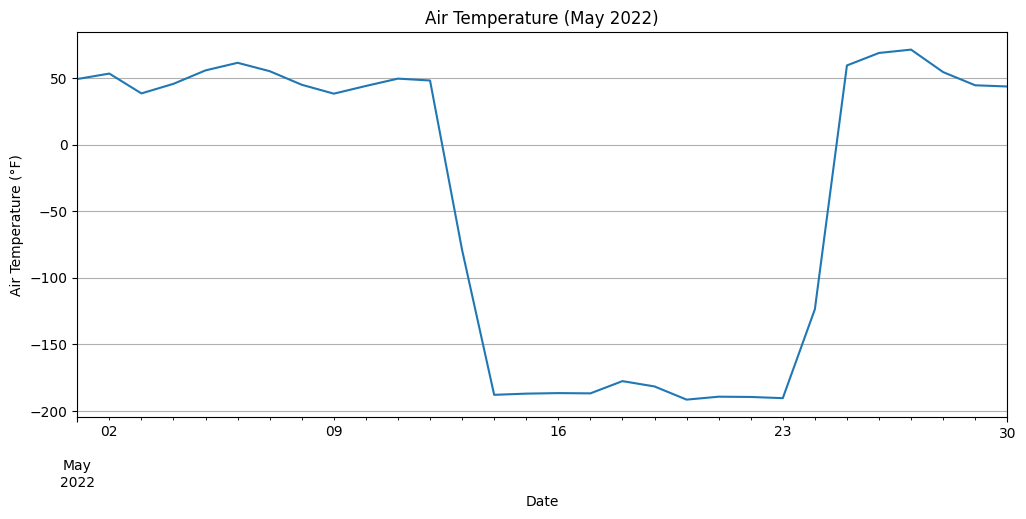

In [897]:
# gsl_df[["airt_avg"]].plot(figsize=(12,6))
import matplotlib.pyplot as plt

# I narrowed down to this range to better see the outlier days, but it was obviously visible in the full dataset. 
subset = gsl_df.loc["2022-05-01":"2022-05-30"]

subset["airt_avg"].plot(figsize=(12,5))
plt.title("Air Temperature (May 2022)")
plt.xlabel("Date")
plt.ylabel("Air Temperature (°F)")
plt.grid(True)
plt.show()

In [898]:
# remove outlier air temperature data to be interpolated later
bad_start = "2022-05-12"
bad_end   = "2022-05-25"

gsl_df.loc[bad_start:bad_end, "airt_avg"] = float("nan")

In [ ]:
# Fill missing data
gsl_df["airt_avg"] = gsl_df["airt_avg"].clip(lower=-40)   # -191.6 degrees F seems extremely low, so we'll use -40 for a realistic minimum

weather_cols = ["airt_avg","netrad_avg","pressure","rh_max","rh_min",
                "swup_avg","winds_avg","winds_max"]
gsl_df[weather_cols] = gsl_df[weather_cols].interpolate(limit_direction="both")
gsl_df["precip"] = gsl_df["precip"].fillna(0)

inflow_cols = ["farmington_inflow","magna_inflow","weber_inflow","corrine_inflow"]
gsl_df[inflow_cols] = gsl_df[inflow_cols].interpolate(limit_direction="both")
gsl_df["elevation_ft"] = gsl_df["elevation_ft"].interpolate(limit_direction="both")

print(gsl_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2863 entries, 2018-02-07 to 2025-12-09
Freq: D
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   elevation_ft       2863 non-null   float64
 1   airt_avg           2863 non-null   float64
 2   netrad_avg         2863 non-null   float64
 3   precip             2863 non-null   float64
 4   pressure           2863 non-null   float64
 5   rh_max             2863 non-null   float64
 6   rh_min             2863 non-null   float64
 7   swup_avg           2863 non-null   float64
 8   winds_avg          2863 non-null   float64
 9   winds_max          2863 non-null   float64
 10  farmington_inflow  2863 non-null   float64
 11  magna_inflow       2863 non-null   float64
 12  weber_inflow       2863 non-null   float64
 13  corrine_inflow     2863 non-null   float64
dtypes: float64(14)
memory usage: 400.0 KB
None


[Back to top](#great-salt-lake-elevation-prediction-with-neural-networks)

### 4. Feature Engineering

In [ ]:
gsl_fe = gsl_df.copy()

gsl_fe["elevation_change"] = gsl_fe["elevation_ft"].diff()

# lag features for predictive modeling
lag_cols = [
    "elevation_ft",
    "farmington_inflow",
    "magna_inflow",
    "weber_inflow",
    "corrine_inflow",
    "precip",
    "airt_avg",
    "netrad_avg",
	"winds_avg", 
    "winds_max",
	"rh_min", 
    "rh_max"
]
lags = [1, 2, 3, 7, 14, 30, 60]
for col in lag_cols:
    for lag in lags:
        gsl_fe[f"{col}_lag{lag}"] = gsl_fe[col].shift(lag)

# date-based features for seasonality
gsl_fe["dayofyear"] = gsl_fe.index.dayofyear
gsl_fe["month"] = gsl_fe.index.month
gsl_fe["sin_doy"] = np.sin(2 * np.pi * gsl_fe["dayofyear"] / 365.25)
gsl_fe["cos_doy"] = np.cos(2 * np.pi * gsl_fe["dayofyear"] / 365.25)

# elevation taget features
gsl_fe["tomorrow_change"] = gsl_fe["elevation_change"].shift(-1)
gsl_fe["tomorrow_elevation"] = gsl_fe["elevation_ft"].shift(-1)
gsl_fe["30day_change"] = gsl_fe["elevation_ft"].shift(-30) - gsl_fe["elevation_ft"]


gsl_fe = gsl_fe.dropna().copy()
print(gsl_fe.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2773 entries, 2018-04-08 to 2025-11-09
Freq: D
Columns: 106 entries, elevation_ft to 30day_change
dtypes: float64(104), int32(2)
memory usage: 2.2 MB
None


[Back to top](#great-salt-lake-elevation-prediction-with-neural-networks)

### 5. Data Splitting

In [901]:
train_end = "2021-12-31"
val_end = "2022-12-31"
test_start = "2024-12-31"

# Define target and feature set
target_col = "30day_change"
feature_cols = [c for c in gsl_fe.columns if c != target_col]

# Time-based splits
train_df = gsl_fe[gsl_fe.index <= train_end]
val_df   = gsl_fe[(gsl_fe.index > train_end) & (gsl_fe.index <= val_end)]
test_df  = gsl_fe[gsl_fe.index > test_start]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val   = val_df[feature_cols]
y_val   = val_df[target_col]

X_test  = test_df[feature_cols]
y_test  = test_df[target_col]

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (1364, 105) (1364,)
Validation set: (365, 105) (365,)
Test set: (313, 105) (313,)


[Back to top](#great-salt-lake-elevation-prediction-with-neural-networks)

### 6. Transforming

In [902]:
# Group feature types for different scaling strategies
weather_features = [
    "swup_avg", "pressure",
]
weather_lag_features = [
    col for col in X_train.columns 
    if any(col.startswith(prefix) for prefix in [
        "precip",
        "airt_avg",
        "netrad_avg",
        "winds_avg", 
        "winds_max",
        "rh_min", 
        "rh_max"
    ])
]
weather_features.extend(weather_lag_features)
inflow_features = [
    col for col in X_train.columns 
    if any(col.startswith(prefix) for prefix in [
        "farmington_inflow",
        "magna_inflow",
        "weber_inflow",
        "corrine_inflow"
    ])
]
elevation_features = [
    "elevation_ft", "elevation_ft_lag1", "elevation_ft_lag7"
]
elevation_features = [
    col for col in X_train.columns 
    if any(col.startswith(prefix) for prefix in [
        "elevation_ft"
    ])
]
seasonal_features = [
    "dayofyear", "month", "sin_doy", "cos_doy"
]

# Transform the feature sets with appropriate scalers
preprocessor = ColumnTransformer(
    transformers=[
        ("weather",   StandardScaler(), weather_features),
        ("inflows",   MinMaxScaler(),   inflow_features), # MinMaxScaler may help inflow distributions
        ("elevation", StandardScaler(), elevation_features),
        ("seasonal",  StandardScaler(), seasonal_features),
    ],
    remainder="drop"
)

[Back to top](#great-salt-lake-elevation-prediction-with-neural-networks)

### 7. Training

Set models to be trained at `Run All`

In [903]:
set_dummy = True
set_ridge = True
set_rf    = True
set_gbr   = True
set_mlp   = True

Dummy Model for baseline

In [904]:
dummy_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DummyRegressor(strategy="mean"))
    ]
)
if set_dummy:
    dummy_model.fit(X_train, y_train)
    print("Dummy model trained.")
else:
    print("Dummy model training skipped.")

Dummy model trained.


Linear Model: Ridge

In [905]:
ridge_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", Ridge(alpha=1.0, random_state=42))
    ]
)
if set_ridge:
    ridge_model.fit(X_train, y_train)
    print("Ridge model trained.")
else:
    print("Ridge model training skipped.")

Ridge model trained.


Tree Model 1: Random Forest

In [906]:
rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        ))
    ]
)
if set_rf:
    rf_model.fit(X_train, y_train)
    print("Random Forest model trained.")
else:
    print("Random Forest model training skipped.")

Random Forest model trained.


Tree Model 2: Gradient Boosting

In [907]:
gbr_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingRegressor(
            random_state=42
        ))
    ]
)
if set_gbr:
    gbr_model.fit(X_train, y_train)
    print("Gradient Boosting model trained.")
else:
    print("Gradient Boosting model training skipped.")

Gradient Boosting model trained.


NN Model: MLP

In [908]:
mlp_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", MLPRegressor(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            solver="adam",
            max_iter=200,
            random_state=42,
            early_stopping=True
        ))
    ]
)
if set_mlp:
    mlp_model.fit(X_train, y_train)
    print("Neural Network model trained.")
else:
    print("Neural Network model training skipped.")

Neural Network model trained.


[Back to top](#great-salt-lake-elevation-prediction-with-neural-networks)

### 8. Model Evaluation

In [909]:
# set model
model = mlp_model
if model is dummy_model:
    model_name = "Dummy Model"
elif model is ridge_model:
    model_name = "Ridge"
elif model is rf_model:
    model_name = "Random Forest"
elif model is gbr_model:
    model_name = "Gradient Boosting"
elif model is mlp_model:
    model_name = "Neural Network"
else:
    model_name = "Unrecognized Model"
model_name

'Neural Network'

Evaluation Metrics

In [910]:
def evaluate_models(curr_model):
    def metrics_for_split(X, y):
        y_pred = curr_model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y, y_pred)
        return mae, rmse, r2

    results = {}
    results["train"] = metrics_for_split(X_train, y_train)
    results["val"]   = metrics_for_split(X_val,   y_val)
    results["test"]  = metrics_for_split(X_test,  y_test)

    for split, (mae, rmse, r2) in results.items():
        print(f"{split.capitalize():>5} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

print(f"\nDummy Model Evaluation:")
evaluate_models(dummy_model)
print(f"\nRidge Evaluation:")
evaluate_models(ridge_model)
print(f"\nRandom Forest Evaluation:")
evaluate_models(rf_model)
print(f"\nGradient Boosting Evaluation:")
evaluate_models(gbr_model)
print(f"\nMLP Neural Netowrk Evaluation:")
evaluate_models(mlp_model)


Dummy Model Evaluation:
Train - MAE: 0.2840, RMSE: 0.3322, R²: 0.0000
  Val - MAE: 0.2185, RMSE: 0.2774, R²: -0.0086
 Test - MAE: 0.2370, RMSE: 0.2852, R²: -0.0042

Ridge Evaluation:
Train - MAE: 0.0905, RMSE: 0.1164, R²: 0.8773
  Val - MAE: 0.1297, RMSE: 0.1658, R²: 0.6396
 Test - MAE: 0.1101, RMSE: 0.1367, R²: 0.7693

Random Forest Evaluation:
Train - MAE: 0.0297, RMSE: 0.0390, R²: 0.9862
  Val - MAE: 0.1423, RMSE: 0.1833, R²: 0.5598
 Test - MAE: 0.1217, RMSE: 0.1545, R²: 0.7055

Gradient Boosting Evaluation:
Train - MAE: 0.0661, RMSE: 0.0840, R²: 0.9361
  Val - MAE: 0.1729, RMSE: 0.2099, R²: 0.4225
 Test - MAE: 0.1210, RMSE: 0.1527, R²: 0.7121

MLP Neural Netowrk Evaluation:
Train - MAE: 0.0665, RMSE: 0.0963, R²: 0.9161
  Val - MAE: 0.2172, RMSE: 0.2797, R²: -0.0258
 Test - MAE: 0.1507, RMSE: 0.1940, R²: 0.5353


Evaluation Plots

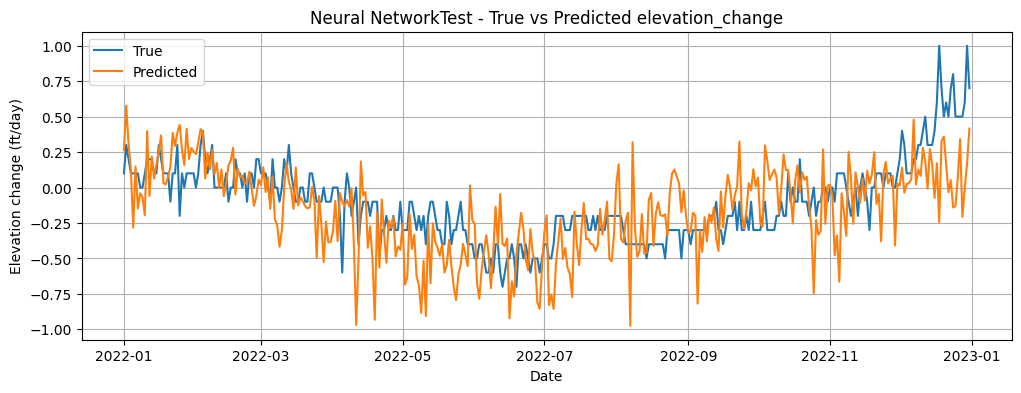

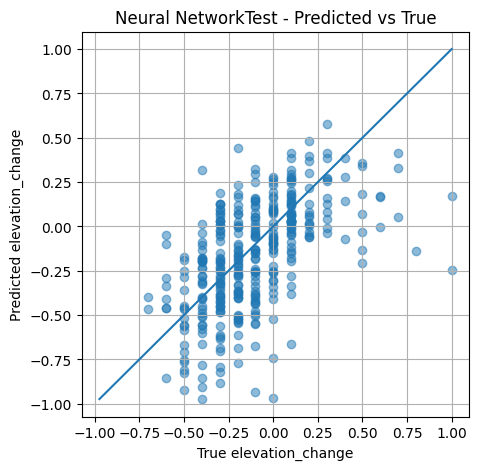

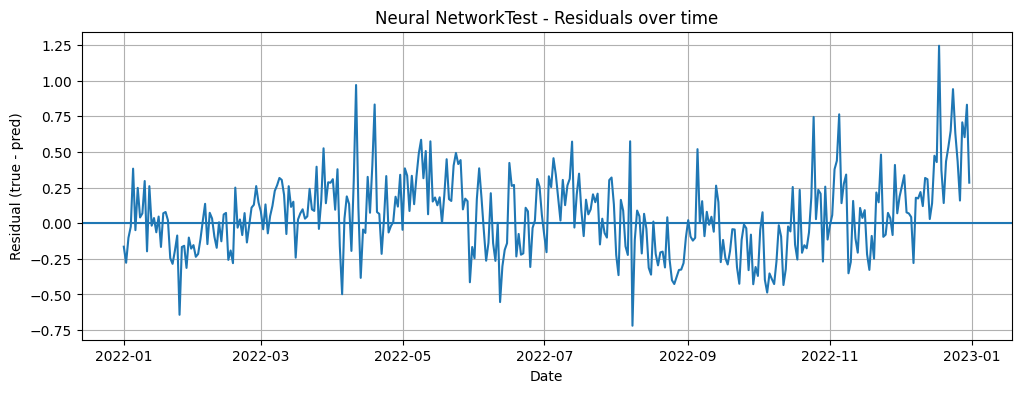

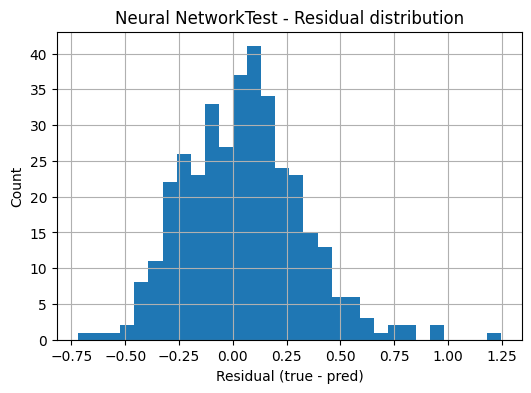

In [ ]:
def plot_model_performance(model, model_name, X, y, dates):
    title_prefix = model_name + "Test"

    y_pred = model.predict(X)

    # Time series
    plt.figure(figsize=(12, 4))
    plt.plot(dates, y, label="True")
    plt.plot(dates, y_pred, label="Predicted")
    plt.title(f"{title_prefix} - True vs Predicted elevation_change")
    plt.xlabel("Date")
    plt.ylabel("Elevation change (ft/day)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Predicted vs True scatter
    plt.figure(figsize=(5, 5))
    plt.scatter(y, y_pred, alpha=0.5)
    min_val = min(y.min(), y_pred.min())
    max_val = max(y.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.title(f"{title_prefix} - Predicted vs True")
    plt.xlabel("True elevation_change")
    plt.ylabel("Predicted elevation_change")
    plt.grid(True)
    plt.show()

    # Residuals over time
    residuals = y - y_pred
    plt.figure(figsize=(12, 4))
    plt.plot(dates, residuals)
    plt.axhline(0)
    plt.title(f"{title_prefix} - Residuals over time")
    plt.xlabel("Date")
    plt.ylabel("Residual (true - pred)")
    plt.grid(True)
    plt.show()

    # Residual histogram
    plt.figure(figsize=(6, 4))
    plt.hist(residuals, bins=30)
    plt.title(f"{title_prefix} - Residual distribution")
    plt.xlabel("Residual (true - pred)")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# plot_model_performance(model, model_name, X_test, y_test, test_df.index)
plot_model_performance(model, model_name, X_val, y_val, val_df.index)

[Back to top](#great-salt-lake-elevation-prediction-with-neural-networks)

### 8. Hyperparameter Tuning

In [ ]:
re_tune = False

In [ ]:
rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

param_distributions = {
    "model__n_estimators": [100, 200, 400, 800],
    "model__max_depth": [5, 10, 20, 40, None],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "model__bootstrap": [True, False],
}

tscv = TimeSeriesSplit(n_splits=5)

rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=40,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)
if re_tune:
    rf_random_search.fit(X_train, y_train)

    print("Best params:", rf_random_search.best_params_)
    print("Best CV MAE:", -rf_random_search.best_score_)

    best_rf_model = rf_random_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END model__bootstrap=False, model__max_depth=20, model__max_features=0.3, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   0.2s
[CV] END model__bootstrap=False, model__max_depth=20, model__max_features=0.3, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   0.3s
[CV] END model__bootstrap=False, model__max_depth=20, model__max_features=0.3, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=0.8, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   0.7s
[CV] END model__bootstrap=False, model__max_depth=20, model__max_features=0.3, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; total time=   0.9s
[CV] END model__bootstrap=False, model__max_dept

Hyperparameter tuning on random forest:
Best params: {'model__n_estimators': 400, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 5, 'model__bootstrap': True}


In [914]:
if re_tune:
    evaluate_models(best_rf_model)

Train - MAE: 0.0916, RMSE: 0.1184, R²: 0.8731
  Val - MAE: 0.1318, RMSE: 0.1753, R²: 0.5969
 Test - MAE: 0.1142, RMSE: 0.1401, R²: 0.7579


Next day prediction
- Train - MAE: 0.0515, RMSE: 0.0803, R²: 0.1748
- Val - MAE: 0.0589, RMSE: 0.0926, R²: 0.0090
- Test - MAE: 0.0569, RMSE: 0.0847, R²: 0.0528

30 day prediction
- Train - MAE: 0.0916, RMSE: 0.1184, R²: 0.8731
- Val - MAE: 0.1318, RMSE: 0.1753, R²: 0.5969
- Test - MAE: 0.1142, RMSE: 0.1401, R²: 0.7579

In [ ]:
ridge_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", Ridge(random_state=42))
    ]
)

param_distributions = {
    "model__alpha": np.logspace(-4, 3, 50),
    "model__fit_intercept": [True, False],
    "model__tol": [1e-4, 1e-3, 1e-2],
}

tscv = TimeSeriesSplit(n_splits=5)

ridge_random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=100,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

if re_tune:
    ridge_random_search.fit(X_train, y_train)

    print("Best params:", ridge_random_search.best_params_)
    print("Best CV MAE:", -ridge_random_search.best_score_)

    best_ridge_model = ridge_random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END model__alpha=5.1794746792312125, model__fit_intercept=False, model__tol=0.01; total time=   0.0s
[CV] END model__alpha=5.1794746792312125, model__fit_intercept=False, model__tol=0.01; total time=   0.0s
[CV] END model__alpha=5.1794746792312125, model__fit_intercept=False, model__tol=0.01; total time=   0.0s
[CV] END model__alpha=5.1794746792312125, model__fit_intercept=False, model__tol=0.01; total time=   0.0s
[CV] END model__alpha=5.1794746792312125, model__fit_intercept=False, model__tol=0.01; total time=   0.0s
[CV] END model__alpha=193.06977288832496, model__fit_intercept=True, model__tol=0.01; total time=   0.0s
[CV] END model__alpha=193.06977288832496, model__fit_intercept=True, model__tol=0.01; total time=   0.0s
[CV] END model__alpha=193.06977288832496, model__fit_intercept=True, model__tol=0.01; total time=   0.0s
[CV] END model__alpha=193.06977288832496, model__fit_intercept=True, model__tol=0.01; total 

Best params: {'model__tol': 0.001, 'model__fit_intercept': True, 'model__alpha': np.float64(1000.0)}
Best CV MAE: 0.055401412184886124

In [916]:
if re_tune:
    evaluate_models(best_ridge_model)

Train - MAE: 0.1247, RMSE: 0.1622, R²: 0.7617
  Val - MAE: 0.1544, RMSE: 0.1930, R²: 0.5118
 Test - MAE: 0.1072, RMSE: 0.1344, R²: 0.7771


next day prediction
- Train - MAE: 0.0550, RMSE: 0.0856, R²: 0.0633
- Val - MAE: 0.0584, RMSE: 0.0920, R²: 0.0224
- Test - MAE: 0.0579, RMSE: 0.0852, R²: 0.0409

30 day prediction
- Train - MAE: 0.1247, RMSE: 0.1622, R²: 0.7617
- Val - MAE: 0.1544, RMSE: 0.1930, R²: 0.5118
- Test - MAE: 0.1072, RMSE: 0.1344, R²: 0.7771

In [ ]:
mlp_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", MLPRegressor(
            max_iter=500,
            early_stopping=True,
            random_state=42
        ))
    ]
)

param_distributions = {
    "model__hidden_layer_sizes": [
        (64,),
        (128,),
        (64, 32),
        (128, 64),
        (128, 64, 32),
        (256, 128)
    ],
    "model__alpha": np.logspace(-5, -1, 5),
    "model__learning_rate_init": np.logspace(-4, -2, 3),
    "model__activation": ["relu", "tanh"],
    "model__batch_size": [32, 64, 128]
}

tscv = TimeSeriesSplit(n_splits=5)

mlp_random_search = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_distributions,
    n_iter=40,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

if re_tune:
    mlp_random_search.fit(X_train, y_train)

    print("Best params:", mlp_random_search.best_params_)
    print("Best CV MAE:", -mlp_random_search.best_score_)

    best_mlp_model = mlp_random_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END model__activation=relu, model__alpha=0.0001, model__batch_size=64, model__hidden_layer_sizes=(64,), model__learning_rate_init=0.001; total time=   0.1s
[CV] END model__activation=relu, model__alpha=0.0001, model__batch_size=64, model__hidden_layer_sizes=(64,), model__learning_rate_init=0.001; total time=   0.2s
[CV] END model__activation=relu, model__alpha=0.0001, model__batch_size=64, model__hidden_layer_sizes=(64,), model__learning_rate_init=0.001; total time=   0.3s
[CV] END model__activation=relu, model__alpha=0.0001, model__batch_size=64, model__hidden_layer_sizes=(64,), model__learning_rate_init=0.001; total time=   0.3s
[CV] END model__activation=relu, model__alpha=0.1, model__batch_size=32, model__hidden_layer_sizes=(128, 64, 32), model__learning_rate_init=0.001; total time=   0.3s
[CV] END model__activation=relu, model__alpha=0.1, model__batch_size=32, model__hidden_layer_sizes=(128, 64, 32), model__learnin

/Users/tylernelson/Desktop/IS P2/is_project/is_project_2/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END model__activation=relu, model__alpha=0.0001, model__batch_size=64, model__hidden_layer_sizes=(64,), model__learning_rate_init=0.0001; total time=   1.2s
[CV] END model__activation=relu, model__alpha=0.0001, model__batch_size=64, model__hidden_layer_sizes=(64,), model__learning_rate_init=0.0001; total time=   1.2s
[CV] END model__activation=relu, model__alpha=0.1, model__batch_size=128, model__hidden_layer_sizes=(256, 128), model__learning_rate_init=0.001; total time=   0.8s
Best params: {'model__learning_rate_init': np.float64(0.01), 'model__hidden_layer_sizes': (128, 64), 'model__batch_size': 128, 'model__alpha': np.float64(0.01), 'model__activation': 'tanh'}
Best CV MAE: 0.21416049869283887


Best params: {'model__learning_rate_init': np.float64(0.01), 'model__hidden_layer_sizes': (64, 32), 'model__batch_size': 32, 'model__alpha': np.float64(0.1), 'model__activation': 'tanh'}
Best CV MAE: 0.06050879578064714

In [918]:
if re_tune:
    evaluate_models(best_mlp_model)

Train - MAE: 0.0490, RMSE: 0.0720, R²: 0.9530
  Val - MAE: 0.2103, RMSE: 0.2729, R²: 0.0240
 Test - MAE: 0.1523, RMSE: 0.1957, R²: 0.5271


Next Day prediction
- Train - MAE: 0.0595, RMSE: 0.0843, R²: 0.0917
- Val - MAE: 0.0638, RMSE: 0.0930, R²: 0.0007
- Test - MAE: 0.0636, RMSE: 0.0867, R²: 0.0077

30 day prediction
- Train - MAE: 0.0490, RMSE: 0.0720, R²: 0.9530
- Val - MAE: 0.2103, RMSE: 0.2729, R²: 0.0240
- Test - MAE: 0.1523, RMSE: 0.1957, R²: 0.5271

[Back to top](#great-salt-lake-elevation-prediction-with-neural-networks)

### 9. Sequence Model

Feature engineering:

In [935]:
gsl_seq = gsl_df.copy()

gsl_seq["change"] = gsl_seq["elevation_ft"].diff(30)
gsl_seq["target"] = gsl_seq["change"].shift(-30)

# Seasonal features
gsl_seq["dayofyear"] = gsl_seq.index.dayofyear
gsl_seq["month"] = gsl_seq.index.month
gsl_seq["sin_doy"] = np.sin(2 * np.pi * gsl_seq["dayofyear"] / 365.25)
gsl_seq["cos_doy"] = np.cos(2 * np.pi * gsl_seq["dayofyear"] / 365.25)

gsl_seq = gsl_seq.dropna().copy()

Data Splitting

In [936]:
feature_cols = [
    "elevation_ft",
    "farmington_inflow", "magna_inflow", "weber_inflow", "corrine_inflow",
    "precip", "airt_avg", "netrad_avg", "winds_avg", "winds_max", "pressure", "swup_avg", "rh_min", "rh_max",
]
target_col = "target"

train_end = "2021-12-31"
val_end   = "2022-12-31"
test_start = "2024-12-31"

train_df = gsl_seq[gsl_seq.index <= train_end]
val_df = gsl_seq[(gsl_seq.index > train_end) & (gsl_seq.index <= val_end)]
test_df = gsl_seq[gsl_seq.index > test_start]

Transformations

In [937]:
scaler = StandardScaler()
train_features_2d = train_df[feature_cols].values
scaler.fit(train_features_2d)

def transform_features(df):
    arr = df[feature_cols].values
    arr_scaled = scaler.transform(arr)
    return arr_scaled

train_features_scaled = transform_features(train_df)
val_features_scaled = transform_features(val_df)
test_features_scaled = transform_features(test_df)

train_targets = train_df[target_col].values
val_targets = val_df[target_col].values
test_targets = test_df[target_col].values

Create Sequences

In [ ]:
def create_sequences(features_2d, targets_1d, seq_len):
    X_list = []
    y_list = []
    for t in range(seq_len - 1, len(features_2d) - 1):
        X_list.append(features_2d[t - seq_len + 1 : t + 1])
        y_list.append(targets_1d[t])
    return np.array(X_list), np.array(y_list)

seq_len = 30

X_train_seq, y_train_seq = create_sequences(train_features_scaled, train_targets, seq_len)
X_val_seq,   y_val_seq   = create_sequences(val_features_scaled,   val_targets,   seq_len)
X_test_seq,  y_test_seq  = create_sequences(test_features_scaled,  test_targets,  seq_len)

print("X_train_seq shape:", X_train_seq.shape)  # samples, seq_len, n_features
print("y_train_seq shape:", y_train_seq.shape)

X_train_seq shape: (1364, 30, 14)
y_train_seq shape: (1364,)


Train

In [ ]:
n_features = X_train_seq.shape[2]

model = models.Sequential([
    layers.Input(shape=(seq_len, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0268 - mae: 0.1265 - val_loss: 0.0355 - val_mae: 0.1463
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - mae: 0.1015 - val_loss: 0.0374 - val_mae: 0.1522
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - mae: 0.0948 - val_loss: 0.0352 - val_mae: 0.1520
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - mae: 0.0877 - val_loss: 0.0373 - val_mae: 0.1577
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - mae: 0.0824 - val_loss: 0.0461 - val_mae: 0.1781
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - mae: 0.0814 - val_loss: 0.0411 - val_mae: 0.1647
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 - mae: 0.0791 - val_loss: 0.0452 - val_mae: 0.1751
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - mae: 0.0731 - val_loss: 0.0414 - val_mae: 0.1647


In [940]:
def eval_regression(y_true, y_pred, split_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{split_name:>5} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return mae, rmse, r2

# Predictions
y_train_pred = model.predict(X_train_seq).ravel()
y_val_pred   = model.predict(X_val_seq).ravel()
y_test_pred  = model.predict(X_test_seq).ravel()

print("LSTM Evaluation:")
eval_regression(y_train_seq, y_train_pred, "Train")
eval_regression(y_val_seq,   y_val_pred,   "Val")
eval_regression(y_test_seq,  y_test_pred,  "Test")

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Evaluation:
Train - MAE: 0.0891, RMSE: 0.1168, R²: 0.8763
  Val - MAE: 0.1520, RMSE: 0.1875, R²: 0.5348
 Test - MAE: 0.1356, RMSE: 0.1804, R²: 0.5900


(0.13562827085739826, 0.18037101949125767, 0.5900450181722982)

### 10. Sequence Model Hyperparameter Tuning

In [ ]:
# Utility: evaluation
def eval_regression(y_true, y_pred, split_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{split_name:>5} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return mae, rmse, r2

def build_lstm_model(
    seq_len,
    n_features,
    lstm_units=64,
    lstm_layers=1,
    dense_units=32,
    dropout_rate=0.0,
    lr=1e-3,
):
    model = models.Sequential()
    model.add(layers.Input(shape=(seq_len, n_features)))

    # First LSTM layer
    if lstm_layers == 1:
        model.add(layers.LSTM(lstm_units))
    else:
        # Multiple LSTM layers
        for i in range(lstm_layers - 1):
            model.add(layers.LSTM(lstm_units, return_sequences=True))
            if dropout_rate > 0:
                model.add(layers.Dropout(dropout_rate))
        # Final LSTM
        model.add(layers.LSTM(lstm_units))

    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))

    # Dense head
    if dense_units is not None and dense_units > 0:
        model.add(layers.Dense(dense_units, activation="relu"))

    model.add(layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"],
    )
    return model


seq_len = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

param_grid = {
    "lstm_units": [32, 64, 128],
    "lstm_layers": [1, 2],
    "dense_units": [0, 32],
    "dropout_rate": [0.0, 0.2],
    "lr": [1e-3, 3e-4],
}

def hyperparameter_search_lstm(
    X_train, y_train,
    X_val, y_val,
    param_grid,
    max_epochs=50,
    batch_size=32,
    patience=5
):
    best_config = None
    best_val_mae = np.inf
    best_model = None

    keys = list(param_grid.keys())
    values_product = list(product(*[param_grid[k] for k in keys]))

    print(f"Total combinations: {len(values_product)}")

    for i, combo in enumerate(values_product, start=1):
        params = dict(zip(keys, combo))
        print(f"\n=== Combo {i}/{len(values_product)}: {params} ===")

        model = build_lstm_model(
            seq_len=seq_len,
            n_features=n_features,
            lstm_units=params["lstm_units"],
            lstm_layers=params["lstm_layers"],
            dense_units=params["dense_units"],
            dropout_rate=params["dropout_rate"],
            lr=params["lr"],
        )
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True
            )
        ]
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        # Evaluate
        val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation MAE: {val_mae:.4f}")
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_config = params
            best_model = model
            print("New best config!")

    print("\n=== Best config ===")
    print(best_config)
    print(f"Best val MAE: {best_val_mae:.4f}")

    return best_model, best_config

best_lstm_model, best_lstm_config = hyperparameter_search_lstm(
    X_train_seq, y_train_seq,
    X_val_seq,   y_val_seq,
    param_grid=param_grid,
    max_epochs=50,
    batch_size=32,
    patience=5
)

Total combinations: 48

=== Combo 1/48: {'lstm_units': 32, 'lstm_layers': 1, 'dense_units': 0, 'dropout_rate': 0.0, 'lr': 0.001} ===
Validation MAE: 0.1602
-> New best config!

=== Combo 2/48: {'lstm_units': 32, 'lstm_layers': 1, 'dense_units': 0, 'dropout_rate': 0.0, 'lr': 0.0003} ===
Validation MAE: 0.1684

=== Combo 3/48: {'lstm_units': 32, 'lstm_layers': 1, 'dense_units': 0, 'dropout_rate': 0.2, 'lr': 0.001} ===
Validation MAE: 0.1467
-> New best config!

=== Combo 4/48: {'lstm_units': 32, 'lstm_layers': 1, 'dense_units': 0, 'dropout_rate': 0.2, 'lr': 0.0003} ===
Validation MAE: 0.1336
-> New best config!

=== Combo 5/48: {'lstm_units': 32, 'lstm_layers': 1, 'dense_units': 32, 'dropout_rate': 0.0, 'lr': 0.001} ===
Validation MAE: 0.1373

=== Combo 6/48: {'lstm_units': 32, 'lstm_layers': 1, 'dense_units': 32, 'dropout_rate': 0.0, 'lr': 0.0003} ===
Validation MAE: 0.1553

=== Combo 7/48: {'lstm_units': 32, 'lstm_layers': 1, 'dense_units': 32, 'dropout_rate': 0.2, 'lr': 0.001} ===
Val

=== Best config === using all data
- {'lstm_units': 64, 'lstm_layers': 1, 'dense_units': 32, 'dropout_rate': 0.2, 'lr': 0.0003}
- Best val MAE: 0.1789

=== Best config === excluding 2023 and 2024 (but test accidentally does include these years)
{'lstm_units': 32, 'lstm_layers': 2, 'dense_units': 0, 'dropout_rate': 0.2, 'lr': 0.0003}
Best val MAE: 0.1153

=== Best config === excluding 2023 and 2024 and test is 2025
{'lstm_units': 64, 'lstm_layers': 1, 'dense_units': 32, 'dropout_rate': 0.2, 'lr': 0.001}
Best val MAE: 0.1206

In [942]:
# Predictions
y_train_pred = best_lstm_model.predict(X_train_seq).ravel()
y_val_pred = best_lstm_model.predict(X_val_seq).ravel()
y_test_pred = best_lstm_model.predict(X_test_seq).ravel()

print("LSTM Evaluation:")
eval_regression(y_train_seq, y_train_pred, "Train")
eval_regression(y_val_seq, y_val_pred, "Val")
eval_regression(y_test_seq, y_test_pred, "Test")

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Evaluation:
Train - MAE: 0.1144, RMSE: 0.1482, R²: 0.8009
  Val - MAE: 0.1206, RMSE: 0.1618, R²: 0.6537
 Test - MAE: 0.1305, RMSE: 0.1625, R²: 0.6672


(0.13048756333863124, 0.16251243315533376, 0.667205734872455)

LSTM Hyperparameter Tuning Evaluation using all data:
- Train - MAE: 0.1304, RMSE: 0.1648, R²: 0.7127
- Val - MAE: 0.1789, RMSE: 0.2274, R²: 0.3702
- Test - MAE: 0.1140, RMSE: 0.1413, R²: 0.7483

LSTM Evaluation ending in 2021, val 2022, test 2023 - 2025:
- Train - MAE: 0.1056, RMSE: 0.1371, R²: 0.8298
- Val - MAE: 0.1153, RMSE: 0.1569, R²: 0.6744
- Test - MAE: 0.2132, RMSE: 0.2872, R²: -0.0389

LSTM Evaluation excluding 2023 and 2024, test 2025
- Train - MAE: 0.1144, RMSE: 0.1482, R²: 0.8009
- Val - MAE: 0.1206, RMSE: 0.1618, R²: 0.6537
- Test - MAE: 0.1305, RMSE: 0.1625, R²: 0.6672

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


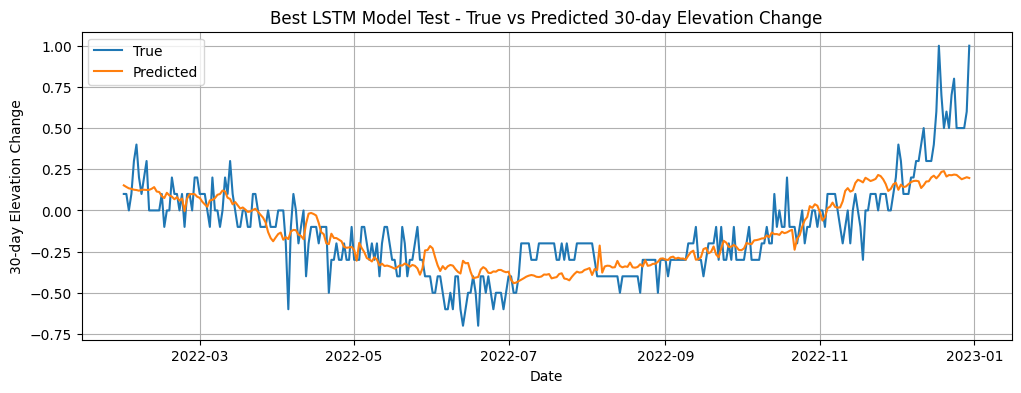

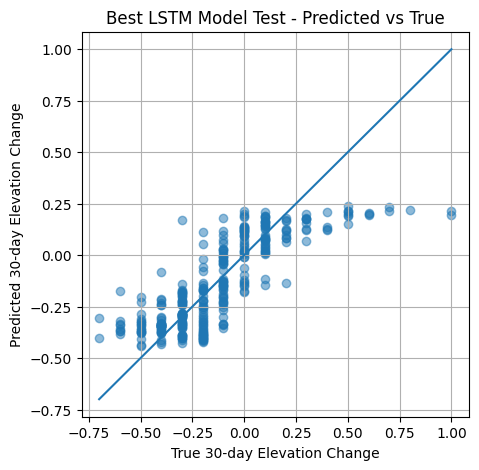

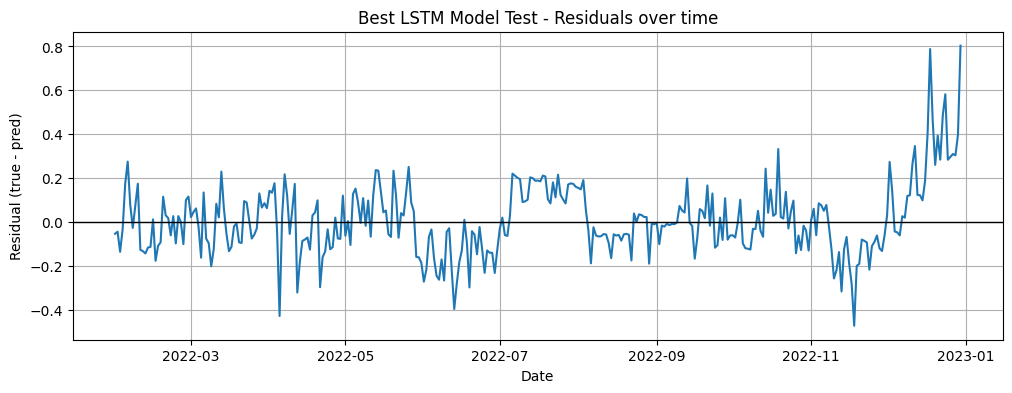

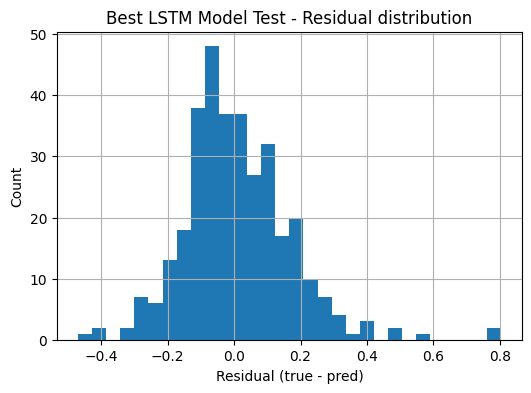

In [ ]:
def plot_model_performance(model, model_name, X, y, dates, target_label="elevation_change"):
    title_prefix = model_name + " Test"

    y_pred = model.predict(X)
    y_pred = np.asarray(y_pred).ravel()
    y_true = np.asarray(y).ravel()

    # Time series
    plt.figure(figsize=(12, 4))
    plt.plot(dates, y_true, label="True")
    plt.plot(dates, y_pred, label="Predicted")
    plt.title(f"{title_prefix} - True vs Predicted {target_label}")
    plt.xlabel("Date")
    plt.ylabel(target_label)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Predicted vs True scatter
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.title(f"{title_prefix} - Predicted vs True")
    plt.xlabel(f"True {target_label}")
    plt.ylabel(f"Predicted {target_label}")
    plt.grid(True)
    plt.show()

    # Residuals over time
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 4))
    plt.plot(dates, residuals)
    plt.axhline(0, color="k", linewidth=1)
    plt.title(f"{title_prefix} - Residuals over time")
    plt.xlabel("Date")
    plt.ylabel("Residual (true - pred)")
    plt.grid(True)
    plt.show()

    # Residual histogram
    plt.figure(figsize=(6, 4))
    plt.hist(residuals, bins=30)
    plt.title(f"{title_prefix} - Residual distribution")
    plt.xlabel("Residual (true - pred)")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

plot_model_performance(
    best_lstm_model,
    "Best LSTM Model",
    X_val_seq,
    y_val_seq,
    val_df.index[seq_len - 1 : len(y_val_seq) + seq_len - 1],  # align dates
    target_label="30-day Elevation Change"
)